In [4]:
import torch
import torchvision
from torch import optim
from torch_snippets import *
from torch.utils.data import DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
device

'cuda'

In [6]:
from torchvision import datasets

data_folder = './CIFAR10'
datasets.CIFAR10(data_folder, download=True)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./CIFAR10
    Split: Train

In [7]:
class Colorize(torchvision.datasets.CIFAR10):
    def __init__(self, root, train):
        super().__init__(root,train)
    def __getitem__(self,ix):
        im,_ = super().__getitem__(ix)
        bw = im.convert('L').convert('RGB')
        bw, im = np.array(bw)/255., np.array(im)/255.
        bw, im = [torch.tensor(i).permute(2,0,1).to(device).float() for i in [bw,im]]
        return bw, im

trn_ds = Colorize(data_folder, train=True)
val_ds = Colorize(data_folder, train=False)

trn_dl = DataLoader(trn_ds, batch_size=256, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=256, shuffle=False)

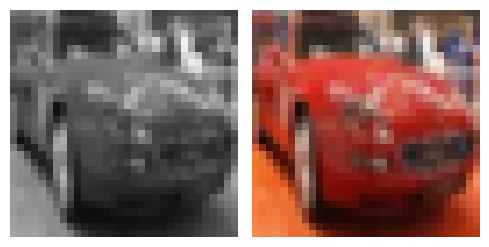

In [8]:
a,b = trn_ds[5]
subplots([a,b], nc=2)

In [ ]:
# Principais alterações feitas são na arquitetura do modelo

import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x

class DownConv(nn.Module):
    def __init__(self, ni, no, maxpool=True, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.MaxPool2d(2) if maxpool else Identity(),
            nn.Conv2d(ni, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout), # Camada de dropout adicionada
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout), # Camada de dropout adicionada
        )
    def forward(self, x):
        return self.model(x)

class UpConv(nn.Module):
    def __init__(self, ni, no, dropout=0.2):
        super().__init__()
        self.convtranspose = nn.ConvTranspose2d(ni, no, 2, stride=2)
        self.convlayers = nn.Sequential(
            nn.Conv2d(no+no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout), # Camada de dropout adicionada
            nn.Conv2d(no, no, 3, padding=1),
            nn.BatchNorm2d(no),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(dropout), # Camada de dropout adicionada
        )
    def forward(self, x, y):
        x = self.convtranspose(x)
        x = torch.cat([x, y], axis=1)
        x = self.convlayers(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DownConv(3, 64, maxpool=False)
        self.d2 = DownConv(64, 128)
        self.d3 = DownConv(128, 256)
        self.d4 = DownConv(256, 512)
        self.d5 = DownConv(512, 1024)
        
        self.u5 = UpConv(1024, 512)
        self.u4 = UpConv(512, 256)
        self.u3 = UpConv(256, 128)
        self.u2 = UpConv(128, 64)
        
        self.u1 = nn.Conv2d(64, 3, kernel_size=1, stride=1)
        self.final_activation = nn.Sigmoid() # Ativação final para garantir que a saída esteja entre 0 e 1
    
    def forward(self, x):
        x0 = self.d1(x)
        x1 = self.d2(x0)
        x2 = self.d3(x1)
        x3 = self.d4(x2)
        x4 = self.d5(x3)
        
        X4 = self.u5(x4, x3)
        X3 = self.u4(X4, x2)
        X2 = self.u3(X3, x1)
        X1 = self.u2(X2, x0)
        X0 = self.u1(X1)
        
        return self.final_activation(X0) # Aplicando a ativação final


In [10]:
def get_model():
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()
    return model, optimizer, loss_fn

In [11]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    x, y = data
    _y = model(x)
    optimizer.zero_grad()
    loss = criterion(_y, y)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    x, y = data
    _y = model(x)
    loss = criterion(_y, y)
    return loss.item()

In [12]:
# Analisando o desempenho do modelo
def train_model(model, trn_dl, val_dl, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        trn_loss = []
        for data in trn_dl:
            loss = train_batch(model, data, optimizer, criterion)
            trn_loss.append(loss)
        
        val_loss = []
        for data in val_dl:
            loss = validate_batch(model, data, criterion)
            val_loss.append(loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {np.mean(trn_loss):.4f}, Validation Loss: {np.mean(val_loss):.4f}')

In [14]:
# Treinando o modelo
model, optimizer, criterion = get_model()
train_model(model, trn_dl, val_dl, optimizer, criterion, epochs=5)

Epoch 1/5, Train Loss: 0.0086, Validation Loss: 0.0055
Epoch 2/5, Train Loss: 0.0067, Validation Loss: 0.0055
Epoch 3/5, Train Loss: 0.0064, Validation Loss: 0.0055
Epoch 4/5, Train Loss: 0.0062, Validation Loss: 0.0052
Epoch 5/5, Train Loss: 0.0061, Validation Loss: 0.0053


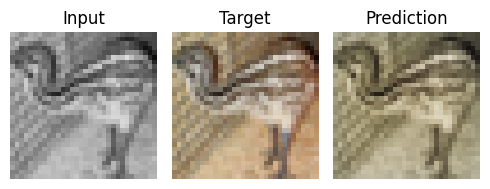

In [29]:
@torch.no_grad()
def predict(model, data):
    model.eval()
    x, y = data
    _y = model(x.unsqueeze(0))
    _y = _y.squeeze(0)
    x, y, _y = [i.cpu().numpy().transpose(1, 2, 0) for i in [x, y, _y]]
    x, y, _y = [np.clip(i, 0, 1) for i in [x, y, _y]]
    subplots([x, y, _y], nc=3, titles=['Input', 'Target', 'Prediction'])
    
predict(model, val_ds[340])